<a href="https://colab.research.google.com/github/skytecat/DL_study/blob/main/morse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle

In [7]:
from google.colab import files
files.upload()  # Загрузите kaggle.json вручную

!mkdir -p ~/.config/kaggle
!mv kaggle.json ~/.config/kaggle/
!chmod 600 ~/.config/kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [8]:
!kaggle competitions download -c morse-decoder

In [10]:
import zipfile

with zipfile.ZipFile("morse-decoder.zip", 'r') as zip_ref:
    zip_ref.extractall("morse_data")  # Распаковка в папку morse_data

In [28]:
!ls

logbook.txt  morse_dataset  sample_submission.csv  test.csv  train.csv


In [20]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(train_df.head())

       id     message
0  1.opus  03ЩУЫЛПИГХ
1  2.opus  ЪЛТ0ДС6А3Г
2  3.opus   5ЭКЫБЗХЯН
3  4.opus   ЖЫЦОИ68КФ
4  5.opus   32Ю7МЫ ЗЛ


In [51]:
from sklearn.model_selection import train_test_split

# Разделение (80% train, 20% validation)
train_data, val_data = train_test_split(
    train_df,
    test_size=0.2,
    random_state=42,  # Для воспроизводимости
)

print(f"Train: {len(train_data)} samples")
print(f"Validation: {len(val_data)} samples")
print(f'Test: {len(test_df)} samples')

Train: 24000 samples
Validation: 6000 samples
Test: 5000 samples


In [52]:
print(train_data.head(5))

               id     message
21753  21754.opus      РГШ28Ф
251      252.opus     ЦЧАЩ3ДМ
22941  22942.opus  2 М #ЮНЭОП
618      619.opus   ТЪ5Ю6Ы0БХ
17090  17091.opus  ФТЗСК ЙЭФТ


In [54]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

# Загрузка аудио
file_path = "morse_dataset/morse_dataset/1.opus"
y, sr = librosa.load(file_path, sr=8000)  # Частота 8 кГц, как в задании

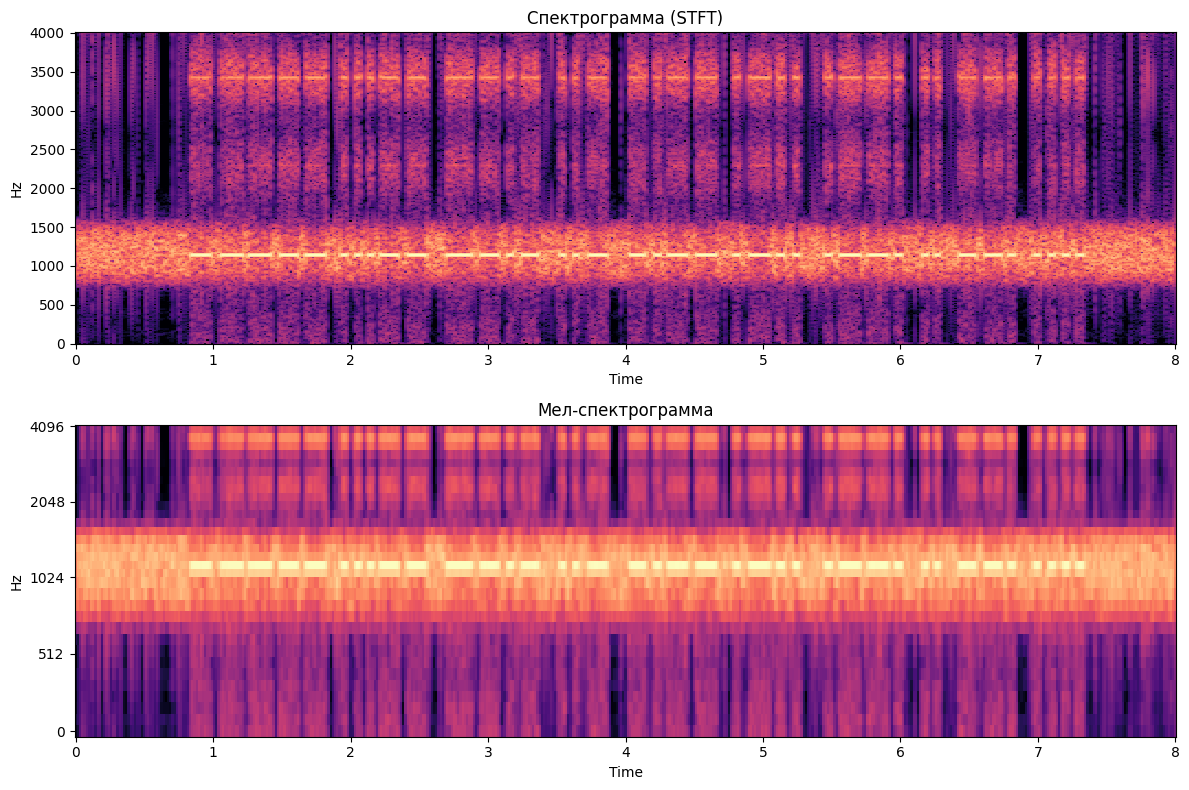

In [55]:
# Спектрограмма
D = librosa.stft(y, n_fft=512, hop_length=128)
S_db = librosa.amplitude_to_db(abs(D), ref=np.max)

# Мел-спектрограмма
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=32)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Отрисовка
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

librosa.display.specshow(S_db, sr=sr, hop_length=128, x_axis='time', y_axis='linear', ax=ax1)
ax1.set_title("Спектрограмма (STFT)")

librosa.display.specshow(mel_spec_db, sr=sr, hop_length=128, x_axis='time', y_axis='mel', ax=ax2)
ax2.set_title("Мел-спектрограмма")

plt.tight_layout()
plt.show()

In [102]:
y_clean = librosa.effects.preemphasis(y)  # Усиление высоких частот
# y_trimmed, _ = librosa.effects.trim(y_clean, top_db=1024)  # Обрезает тихие участки

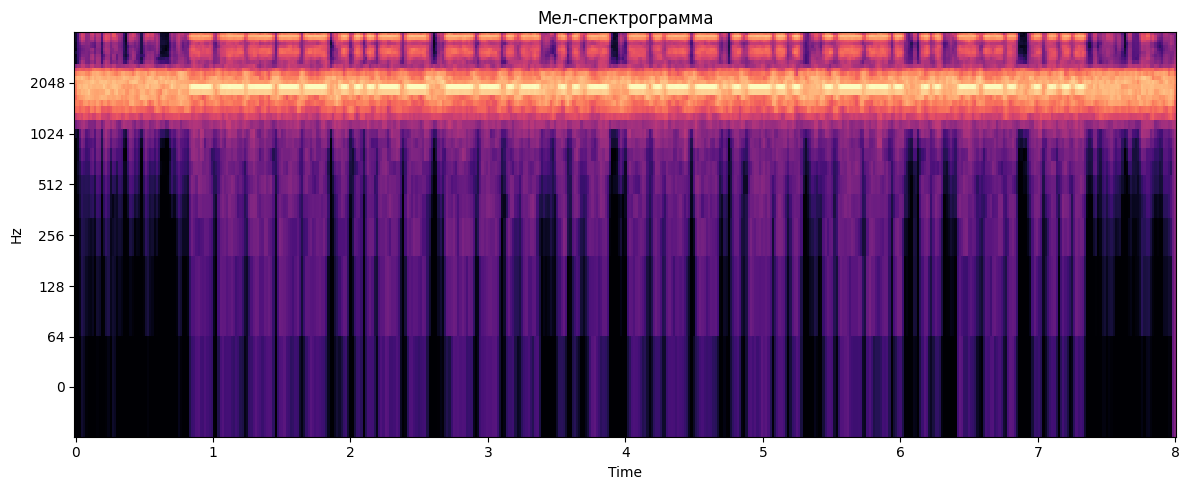

In [105]:
# Спектрограмма
D = librosa.stft(y, n_fft=512, hop_length=128)
S_db = librosa.amplitude_to_db(abs(D), ref=np.max)

# Мел-спектрограмма
mel_spec = librosa.feature.melspectrogram(y=y_clean, sr=sr, n_fft=512, hop_length=128, n_mels=32)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Отрисовка
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 5))

# librosa.display.specshow(mel_spec_db, sr=sr, hop_length=128, x_axis='time', y_axis='mel', ax=ax1)
librosa.display.specshow(mel_spec_db, sr=sr, hop_length=128, x_axis='time', y_axis='log', ax=ax1)

ax1.set_title("Мел-спектрограмма")

plt.tight_layout()
plt.show()

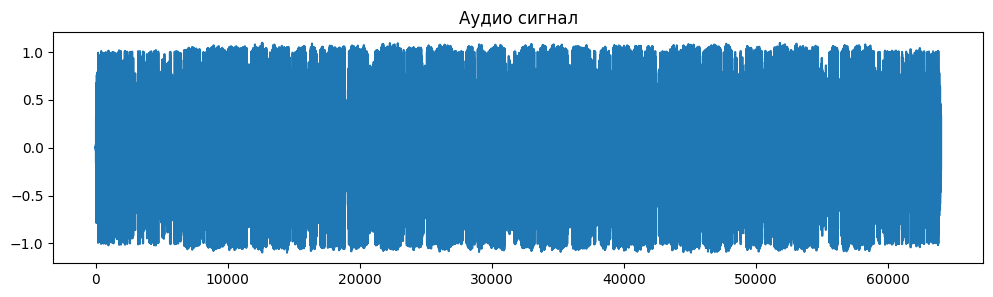

In [32]:
# Визуализация
plt.figure(figsize=(12, 3))
plt.plot(y)
plt.title("Аудио сигнал")
plt.show()


In [33]:
from IPython.display import Audio

# Прослушивание
Audio(file_path, autoplay=True)

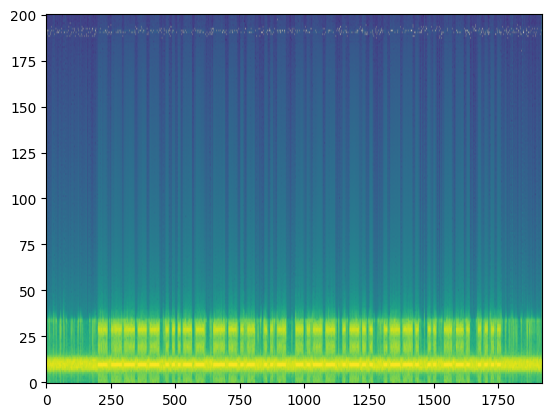

In [35]:
import torchaudio

waveform, sr = torchaudio.load("morse_dataset/morse_dataset/1.opus")  # Загрузка аудио
spectrogram = torchaudio.transforms.Spectrogram()(waveform)  # Спектрограмма
plt.imshow(spectrogram.log2()[0], aspect='auto', origin='lower')

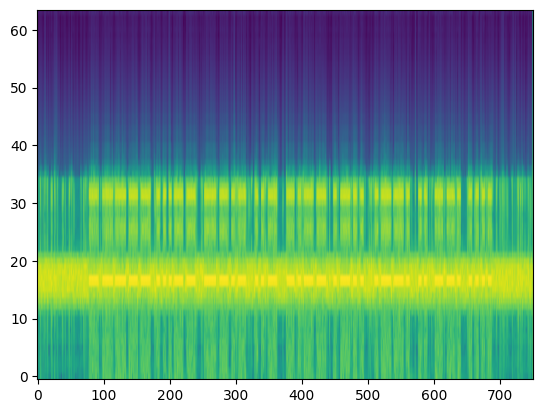

In [36]:
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr,
    n_fft=1024,
    n_mels=64  # Количество мел-фильтров
)
mel_spec = mel_transform(waveform)
plt.imshow(mel_spec.log2()[0], aspect='auto', origin='lower')

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (129) may be set too low.
  warnings.warn(


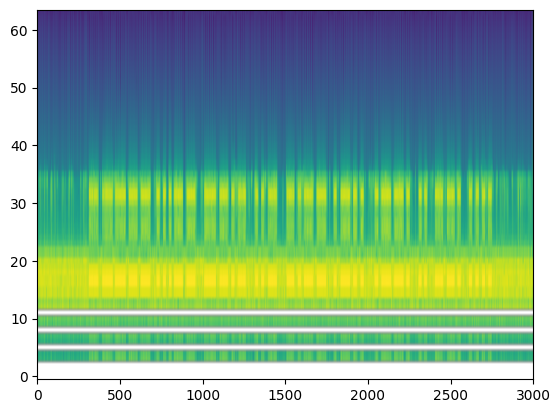

In [37]:
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr,
    n_fft=256,
    n_mels=64  # Количество мел-фильтров
)
mel_spec = mel_transform(waveform)
plt.imshow(mel_spec.log2()[0], aspect='auto', origin='lower')

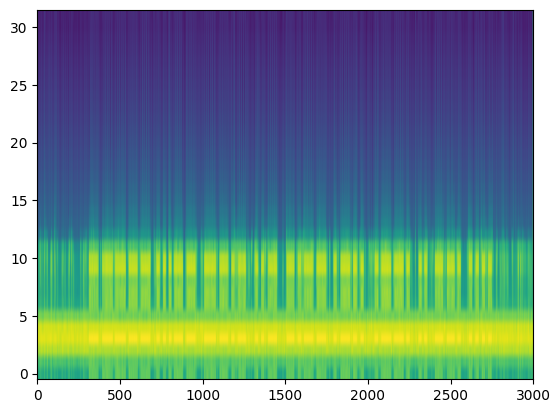

In [41]:
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=8000,      # Частота из условия задачи
    n_fft=512,            # Лучшее временное разрешение для коротких сигналов
    win_length=512,       # = n_fft
    hop_length=128,       # n_fft // 4
    n_mels=32,            # Уменьшаем для тональных сигналов
    power=1.0             # Амплитуда (1.0 = энергия)
)
mel_spec = mel_transform(waveform)
plt.imshow(mel_spec.log2()[0], aspect='auto', origin='lower')


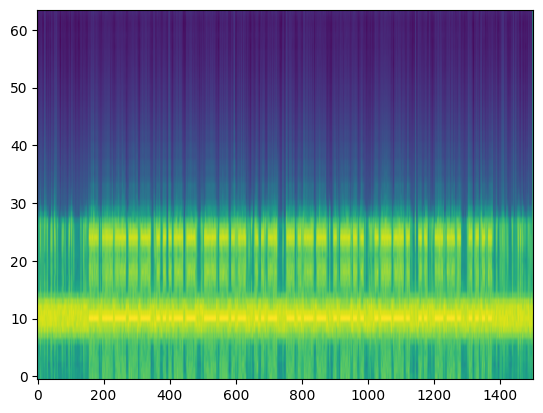

In [46]:
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    n_mels=64,
    power=1.0
)
mel_spec = mel_transform(waveform)
plt.imshow(mel_spec.log2()[0], aspect='auto', origin='lower')